# Chemoinformatics using Python: Predict Solubility with ML and DL models

## Part I : Using pycarnet to explore regression ML

##### This notebook was inspired by the dataprofessor notebook. Link to the youtube video: https://www.youtube.com/watch?v=VXFFHHoE1wk
##### and use the datasets as reported by Meng et al. doi: https://doi.org/10.1038/s41597-022-01154-3

### Package importation

In [1]:
import session_info

import pandas as pd
import numpy as np
from rdkit import Chem
from random import sample
from sklearn.model_selection import train_test_split

from rdkit.Chem.rdMolDescriptors import CalcExactMolWt,CalcNumRotatableBonds,CalcTPSA,CalcNumHBD,CalcNumHBA,CalcFractionCSP3
from rdkit.Chem.Descriptors import MolLogP
from rdkit.Chem.Lipinski import HeavyAtomCount

from pycaret.regression import *

session_info.show()

### Exploratory analysis on the aqsol dataset

#### Import the database

In [2]:
path=r"C:\Users\sylv_\Documents\GitHub\SolCuration\clean\aqsol_stand.csv"
df= pd.read_csv(path)

In [3]:
df

,smiles,logS,weight
0,B12B3B4B1C234,-4.74240,1
1,Br/C=C/Br,-1.74150,1
2,Br/C=C\Br,-1.31950,1
3,BrC(Br)(Br)Br,-3.14040,1
4,BrC(Br)Br,-1.91130,1
...,...,...,...
8696,c1coc(-c2nc3ccccc3[nH]2)c1,-3.41400,1
8697,c1coc(CNc2ncnc3[nH]cnc23)c1,-3.95000,1
8698,c1nc[nH]n1,1.00583,1
8699,c1ncc2[nH]cnc2n1,0.61940,1


In [4]:
df.smiles[4953]

'COc1ccc(Cl)cc1C(=O)NCCc1ccc(S(=O)(=O)NC(=O)NC2CCCCC2)cc1'

#### Convert Smiles string into a RDKit object and working with it

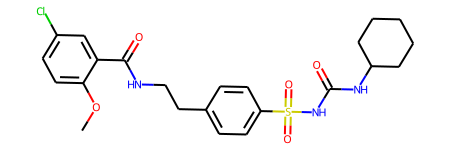

In [5]:
n=Chem.MolFromSmiles(df.smiles[4953])
n

In [6]:
n.GetNumAtoms()

33

#### Calculate molecular descriptor with RDKit

In [7]:
mol_list= [Chem.MolFromSmiles(element) for element in df.smiles]

In [8]:
mol_list[:5]

#### Physico-chemical properties that will be use for Solubility predictions

In [9]:
def generate(mol_liste,verbose = False):
    
    base_data= np.arange(1,1)
    i=0
    for mol in mol_liste:
        descr_Mw= CalcExactMolWt(mol)
        descr_RB=CalcNumRotatableBonds(mol)
        descr_Polar=CalcTPSA(mol)
        descr_Hdonor= CalcNumHBD(mol)
        descr_Hacceptor=CalcNumHBA(mol)
        descr_Fsp3= CalcFractionCSP3(mol)
        descr_logP= MolLogP(mol)
        
        row= np.array([descr_Mw,descr_RB,
                       descr_Polar,descr_Hdonor,
                       descr_Hacceptor,descr_Fsp3,
                       descr_logP,
                      ])
        if (i==0):
            base_data= row
        else:
            base_data = np.vstack([base_data,row])
        i=i+1
        
    colnames= ["MolWt", "RotBond", "Polarity", "Hdonor", "Haccept", "SP3Atom", "logP"]
    descriptor= pd.DataFrame(data= base_data, columns= colnames)
    
    return descriptor
        

In [10]:
df_descrip= generate(mol_list)
df_descrip.sample(n=10)

,MolWt,RotBond,Polarity,Hdonor,Haccept,SP3Atom,logP
5384,391.949927,0.0,34.14,0.0,4.0,0.111111,6.09884
1744,197.141579,1.0,63.32,2.0,2.0,0.909091,1.61470
4533,292.203845,3.0,46.53,1.0,3.0,0.611111,4.09280
422,246.009104,3.0,0.00,0.0,0.0,0.666667,3.64060
432,224.116092,4.0,75.27,2.0,3.0,0.545455,0.96100
6064,323.883389,1.0,0.00,0.0,0.0,0.000000,6.62060
4983,138.068080,2.0,18.46,0.0,2.0,0.250000,1.70380
2350,248.061949,2.0,58.20,2.0,3.0,0.250000,0.86530
2104,342.255880,7.0,26.30,0.0,2.0,0.521739,6.47120
6543,247.070071,2.0,52.32,1.0,4.0,0.900000,2.59070


#### Aromatic proportion

##### 1.Number of aromatic atoms

In [11]:
def Arom_atoms(mol):
    arom_atoms= [mol.GetAtomWithIdx(i).GetIsAromatic() for i  in range(mol.GetNumAtoms())]
    aa_count=[]
    for i in arom_atoms:
        if i == True:
            aa_count.append(1)
    sum_aa_count= sum(aa_count)
    return sum_aa_count

In [12]:
desc_AA= [Arom_atoms(element) for element in mol_list]
print(sample(desc_AA,30))

[0, 6, 11, 0, 11, 6, 6, 5, 0, 12, 10, 6, 0, 0, 0, 18, 6, 22, 0, 6, 12, 6, 12, 6, 6, 0, 0, 0, 6, 6]


##### 2.Number of Heavy Atoms

In [13]:
desc_HeavA= [HeavyAtomCount(element) for element in mol_list]
print(sample(desc_HeavA,30))

[20, 24, 28, 8, 16, 13, 28, 12, 12, 32, 16, 9, 7, 6, 12, 31, 9, 13, 11, 23, 18, 23, 22, 11, 15, 11, 25, 11, 12, 20]


In [14]:
desc_Aromproportion= [Arom_atoms(element)/HeavyAtomCount(element) for element in mol_list]
print(sample(desc_Aromproportion,30))

[0.8333333333333334, 0.5, 0.0, 0.0, 0.0, 0.875, 0.0, 0.0, 0.75, 0.0, 0.6, 0.8888888888888888, 0.9090909090909091, 0.0, 0.0, 0.9090909090909091, 0.0, 0.5789473684210527, 0.0, 0.375, 0.0, 0.3, 0.6, 0.9375, 0.0, 0.0, 0.0, 0.0, 0.42857142857142855, 0.0]


In [15]:
df_descr_Aromprop= pd.DataFrame(desc_Aromproportion, columns= ['Aromproportion'])

## Data Matrice of descriptors

In [16]:
x= pd.concat([df_descrip,df_descr_Aromprop], axis=1)
x.describe()

,MolWt,RotBond,Polarity,Hdonor,Haccept,SP3Atom,logP,Aromproportion
count,8701.000000,8701.000000,8701.000000,8701.000000,8701.000000,8701.000000,8701.000000,8701.000000
mean,246.818141,3.773130,54.578894,1.071371,3.126652,0.439087,2.416538,0.335043
std,126.813210,4.635448,42.294424,1.346715,2.404365,0.345819,2.435002,0.298453
min,40.031300,0.000000,0.000000,0.000000,0.000000,0.000000,-17.406400,0.000000
25%,161.896054,1.000000,26.020000,0.000000,2.000000,0.125000,0.978600,0.000000
50%,224.090940,3.000000,47.360000,1.000000,3.000000,0.400000,2.143600,0.375000
75%,305.917276,5.000000,75.270000,2.000000,4.000000,0.750000,3.527520,0.571429
max,2284.054626,68.000000,633.200000,24.000000,40.000000,1.000000,26.246600,1.000000


## Target Matrice

In [17]:
y= df.iloc[:, 1]
y.describe()

count    8701.000000
mean       -3.001496
std         2.302020
min       -13.171900
25%        -4.349900
50%        -2.701590
75%        -1.418640
max         2.137680
Name: logS, dtype: float64

### Combine x and y

In [18]:
dataset_sol1= pd.concat([x,y], axis=1)
dataset_sol1

,MolWt,RotBond,Polarity,Hdonor,Haccept,SP3Atom,logP,Aromproportion,logS
0,56.037222,0.0,0.00,0.0,0.0,1.0,-1.3084,0.000,-4.74240
1,183.852324,0.0,0.00,0.0,0.0,0.0,2.2474,0.000,-1.74150
2,183.852324,0.0,0.00,0.0,0.0,0.0,2.2474,0.000,-1.31950
3,327.673348,0.0,0.00,0.0,0.0,1.0,3.1773,0.000,-3.14040
4,249.762836,0.0,0.00,0.0,0.0,1.0,2.4547,0.000,-1.91130
...,...,...,...,...,...,...,...,...,...
8696,184.063663,1.0,41.82,1.0,2.0,0.0,2.8229,1.000,-3.41400
8697,215.080710,3.0,79.63,2.0,5.0,0.1,1.5580,0.875,-3.95000
8698,69.032697,0.0,41.57,1.0,2.0,0.0,-0.1953,1.000,1.00583
8699,120.043596,0.0,54.46,1.0,3.0,0.0,0.3529,1.000,0.61940


### Normalization of the dataset

min_vals = dataset_sol1.min()
max_vals = dataset_sol1.max()
ranges = max_vals - min_vals

###### subtract the minimum from each value
dataset_sol1 = dataset_sol1 - min_vals

###### divide by the range
dataset_sol1 = dataset_sol1 / ranges

dataset_sol1

## ML with Pycaret

### Train-Test split

In [19]:
dataset_sol1_train, dataset_sol1_test = train_test_split(dataset_sol1,test_size=0.2)

### Model Setup

In [20]:
model1= setup(data= dataset_sol1_train, target= 'logS', train_size=0.8, verbose = True, remove_outliers = True, outliers_threshold =0.005)

,Description,Value
0,Session id,8492
1,Target,logS
2,Target type,Regression
3,Original data shape,"(6960, 9)"
4,Transformed data shape,"(6933, 9)"
5,Transformed train set shape,"(5541, 9)"
6,Transformed test set shape,"(1392, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


### Model Comparaison

In [21]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.6807,0.9355,0.9665,0.8248,0.2639,1.1027,0.5820
lightgbm,Light Gradient Boosting Machine,0.6976,0.9434,0.9709,0.8233,0.2650,1.1327,0.5020
rf,Random Forest Regressor,0.6902,0.9468,0.9725,0.8227,0.2644,1.0965,0.6770
gbr,Gradient Boosting Regressor,0.7468,1.0424,1.0205,0.8047,0.2806,1.3679,0.5590
ada,AdaBoost Regressor,0.9278,1.4516,1.2045,0.7281,0.3090,2.0394,0.5240
br,Bayesian Ridge,0.9492,1.6998,1.2997,0.6817,0.3323,2.0032,0.4900
lr,Linear Regression,0.9492,1.7002,1.2999,0.6816,0.3324,2.0034,0.8230
ridge,Ridge Regression,0.9492,1.7002,1.2999,0.6816,0.3324,2.0034,0.4990
lar,Least Angle Regression,0.9488,1.7012,1.3003,0.6814,0.3327,1.9982,0.4940
dt,Decision Tree Regressor,0.9251,1.7578,1.3241,0.6708,0.3509,1.3557,0.4880


ExtraTreesRegressor(n_jobs=-1, random_state=8492)

In [22]:
et= create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6982,1.0326,1.0162,0.8039,0.2548,0.6640
1,0.6557,0.8651,0.9301,0.8213,0.2674,1.5768
2,0.7079,1.0170,1.0085,0.8113,0.2740,0.8101
3,0.6833,0.9823,0.9911,0.8138,0.2713,1.6240
4,0.6969,0.9861,0.9930,0.8231,0.2681,2.1904
5,0.6398,0.9080,0.9529,0.8361,0.2572,0.8506
6,0.6453,0.8041,0.8967,0.8493,0.2498,0.7678
7,0.6715,0.8736,0.9347,0.8371,0.2685,0.7775
8,0.7142,0.9603,0.9800,0.8118,0.2710,1.0788


In [23]:
#tuned_et= tune_model(et,n_iter= 50, optimize = 'MAE')

### Model analysis

#### 1. Plot Model

##### Residual Plot

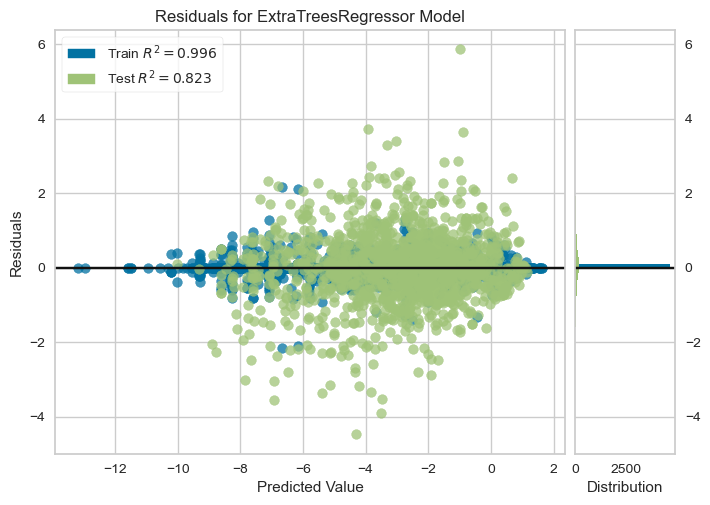

In [24]:
plot_model(et, 'residuals')

##### Prediction error Plot

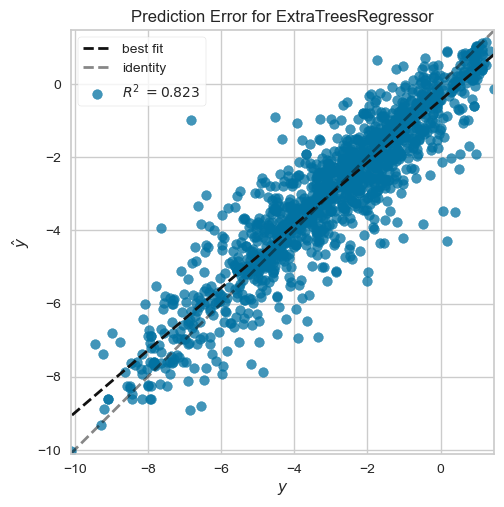

In [25]:
plot_model(et, 'error')

##### Cooks Distance Plot

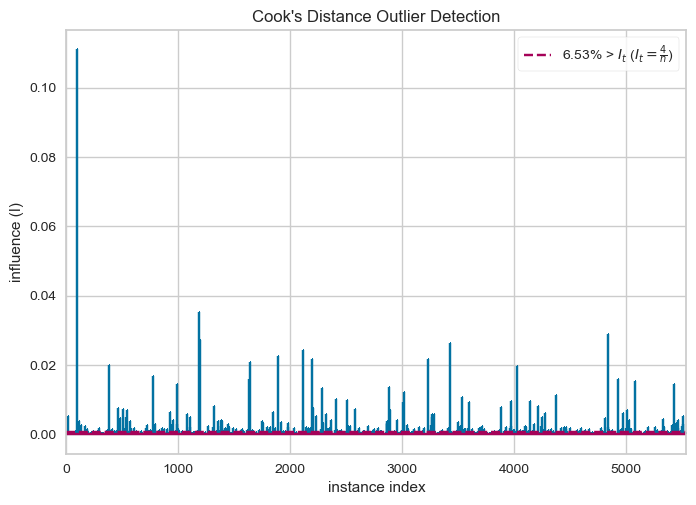

In [26]:
plot_model(et, 'cooks')

##### Recursive Feature Selection

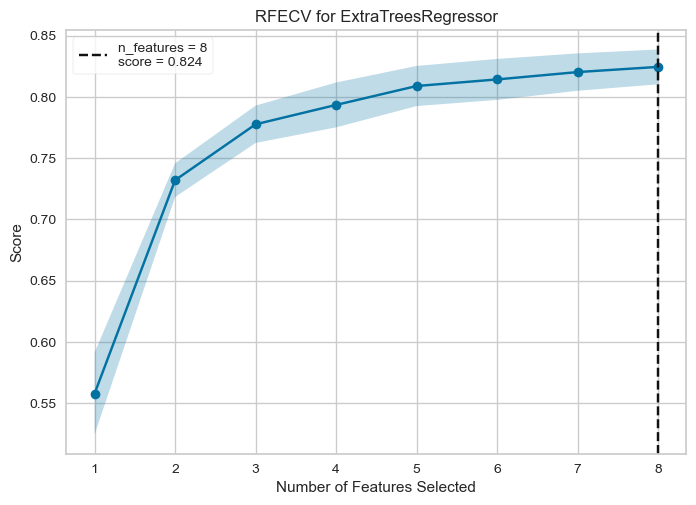

In [27]:
plot_model(et, 'rfe')

##### Learning Curve

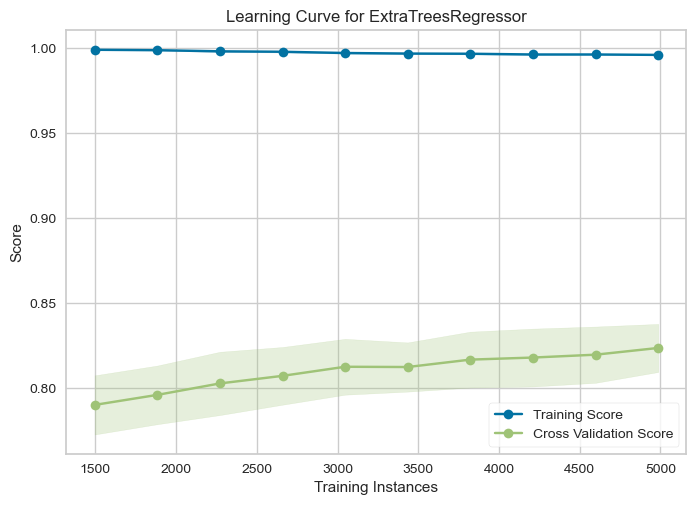

In [28]:
plot_model(et, 'learning')

##### Validation Curve

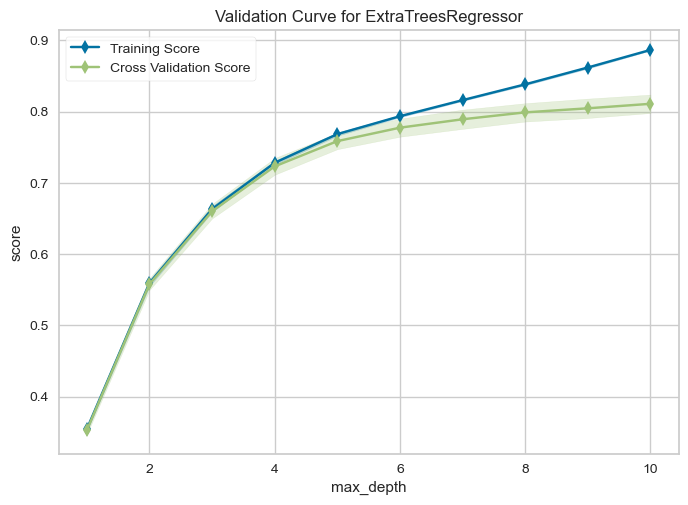

In [29]:
plot_model(et,'vc')

##### Manifold Learning

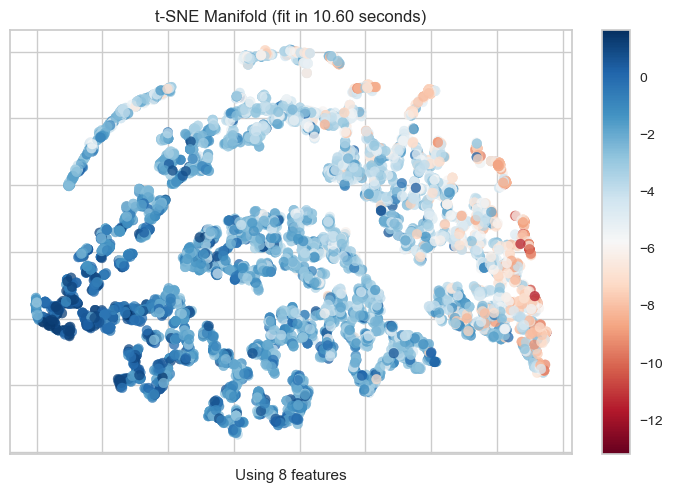

In [30]:
plot_model(et, 'manifold')

##### Feature importance

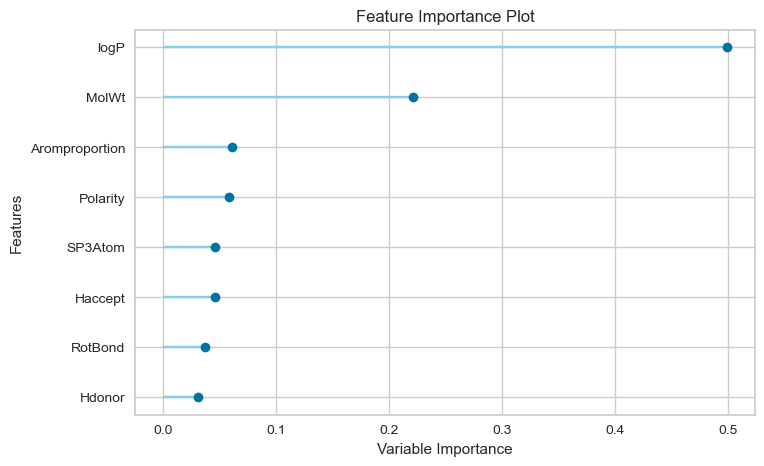

In [31]:
plot_model(et, 'feature')

##### Hyperparameters

In [32]:
plot_model(et, 'parameter')

,Parameters
bootstrap,False
ccp_alpha,0.0
criterion,squared_error
max_depth,None
max_features,1.0
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,1
min_samples_split,2


#### Show all plots

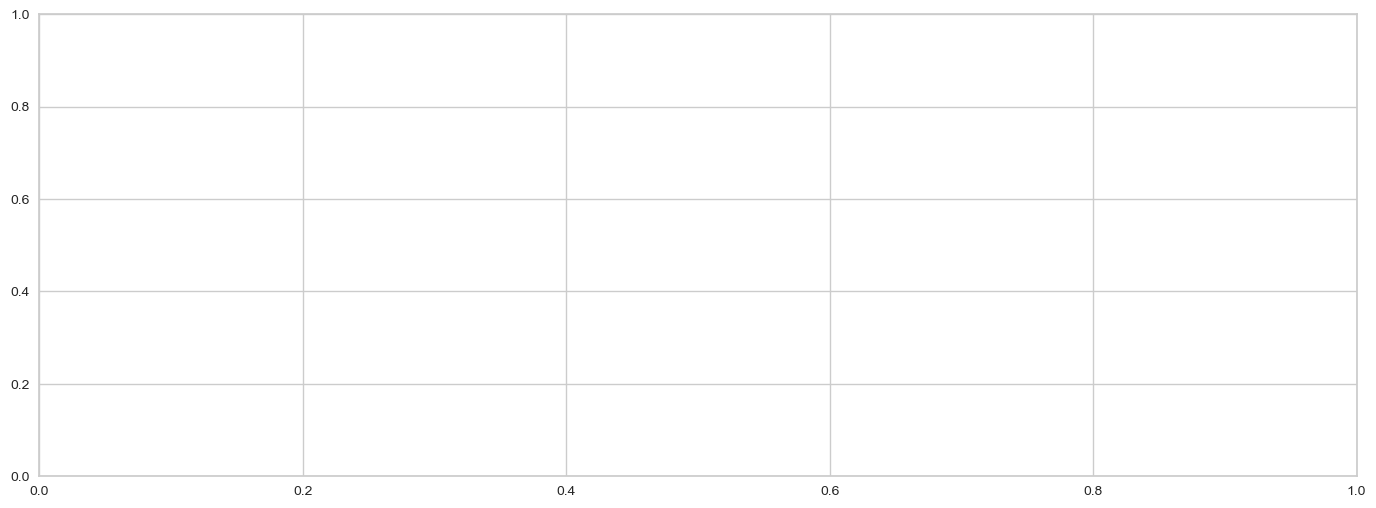

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [33]:
evaluate_model(et)

### 2.Model Interpretation

##### Summary plot

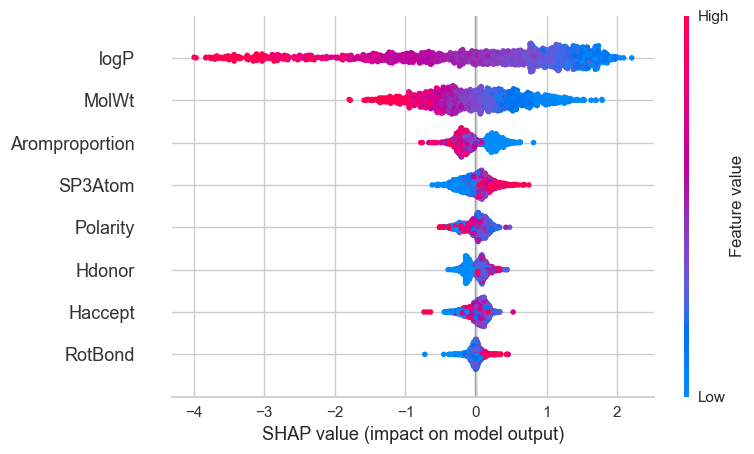

In [34]:
interpret_model(et)

##### Reason Plot

In [35]:
interpret_model(et, plot= 'reason', observation= 20)

#### External Test

In [36]:
prediction_test= predict_model(et,data=dataset_sol1_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.6976,0.9798,0.9899,0.8183,0.2698,0.7822


In [37]:
prediction_test.head()

,MolWt,RotBond,Polarity,Hdonor,Haccept,SP3Atom,logP,Aromproportion,logS,prediction_label
8393,180.063385,1.0,110.379997,5.0,6.0,1.000000,-3.2214,0.000000,0.4433,0.640000
4944,357.168854,9.0,102.680000,3.0,5.0,0.263158,1.5735,0.461538,-2.6900,-2.502680
8258,336.063385,2.0,100.879997,2.0,6.0,0.052632,2.9014,0.800000,-4.2700,-4.071133
7053,210.068085,3.0,34.139999,0.0,2.0,0.000000,2.7522,0.750000,-2.8000,-3.810990
503,99.014267,2.0,12.360000,0.0,2.0,0.250000,1.2752,0.000000,-1.6953,-0.594808
